In [96]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import os
import matplotlib.pyplot as plt

## Read Data

In [6]:
df = pd.read_csv('HW2_data.csv')
df.head()

,y,x1,x2,x3
0,-1.471961,1,-0.626454,-0.383425
1,4.585642,1,1.595281,1.215549
2,3.113337,1,0.487429,0.562698
3,1.018829,1,-0.305388,0.239762
4,-0.216829,1,-0.621241,-1.099278


Extract predictor and response observations

In [ ]:
yi = df['y'].to_numpy()
x1 = df['x1'].to_numpy()
x2 = df['x2'].to_numpy()
x3 = df['x3'].to_numpy()

## Least Squares Linear Regression

Calculate the ordinary least squares (OLS) linear regression model for comparison.

\begin{align}
\hat\beta = (X'X)^{-1}X'y
\end{align}

\begin{align}
\text{where X is the matrix of the independent variables. 
Matrix where each column is a predictor variable and each row has the observations} 
\end{align}

In [14]:
def find_estimators(y, *args):
    X = np.stack((args), axis=1)
    a1 = np.matmul(X.T, X)
    inv_a1 = np.linalg.inv(a1)
    a2 = np.matmul(inv_a1, X.T)
    res = np.matmul(a2, y)
    return res

In [72]:
b1,b2,b3 = find_estimators(yi, x1, x2, x3)
b1,b2,b3

(0.9925764865075013, 2.0805342305653247, 0.7053498780401117)

\begin{align}
y_i & = \beta_{1}x_1 + \beta_{2}x_2+ \beta_{3}x_3+    \epsilon_i \\
y_i & = 0.9925 + 2.080x_2+ 0.7053x_3 +    \epsilon_i
\end{align}

In [73]:
b3 / 1.01

0.6983662158812988

## Bayesian Linear Regression

Initialize Variables

In [21]:
def inv_product_design_mat(*args):
    X = np.stack((args), axis=1)
    a1 = np.matmul(X.T, X)
    inv_a1 = np.linalg.inv(a1)
    return inv_a1


X = np.stack((x1, x2, x3), axis=1)
print('Design Matrix:')
print(X[:5])
print("")
print("(X'X)^{-1}:")
inv_x_prime_x = inv_product_design_mat(x1, x2, x3)
inv_x_prime_x

Design Matrix:
[[ 1.         -0.62645381 -0.38342467]
 [ 1.          1.5952808   1.21554889]
 [ 1.          0.48742905  0.56269775]
 [ 1.         -0.30538839  0.23976248]
 [ 1.         -0.62124058 -1.09927837]]

(X'X)^{-1}:


array([[ 0.03605075,  0.00886407, -0.02331968],
       [ 0.00886407,  0.30290927, -0.37437606],
       [-0.02331968, -0.37437606,  0.52489867]])

In [61]:
with pm.Model() as model:
    
    # Step 1: Specify the Prior Model ---------------------------------
    # Assume B has a multivariate normal prior with:
    #     mean 0 and covariance matrix 100*(X'X)^{-1}
    
    # Extract variances from covariance matrix and take SQRT
    beta_sigma = np.sqrt(np.diag(100*inv_x_prime_x))
    beta = pm.Normal('beta', mu = 0, sigma = beta_sigma, shape=3)        
    sigma = pm.HalfNormal('sigma', sigma = 1.0)            # homoscedastic error in standard deviation
    
    # Step 2: Specify the linear model ---------------------------------
    mu = pm.math.dot(X, beta)
    
    # Step 3 Define the distribution of the predictor and response features
    y_obs = pm.Normal('y_obs', mu = mu, sigma = sigma, observed = yi)
   
    # Step 4: Posterior distribution
    result = pm.sample(draws = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [63]:
# Sigma = [10,10,10] and 3,000 draws
df = pm.stats.summary(result)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.985,0.166,0.676,1.299,0.002,0.001,6414.0,6180.0,1.0
beta[1],2.068,0.480,1.141,2.966,0.007,0.005,4306.0,5035.0,1.0
beta[2],0.724,0.635,-0.492,1.915,0.010,0.007,4267.0,4920.0,1.0
sigma,0.864,0.122,0.651,1.091,0.002,0.001,4229.0,2630.0,1.0


In [66]:
df.loc['beta[2]','sd']**2

0.403225

In [67]:
with pm.Model() as model:
    
    # Step 1: Specify the Prior Model ---------------------------------
    # Assume B has a multivariate normal prior with:
    #     mean 0 and covariance matrix 100*(X'X)^{-1}
    
    # Extract variances from covariance matrix and take SQRT
    beta_sigma = np.sqrt(np.diag(100*inv_x_prime_x))
    beta = pm.Normal('beta', mu = 0, sigma = beta_sigma, shape=3)        
    #sigma = pm.HalfNormal('sigma', sigma = 1.0)            # homoscedastic error in standard deviation
    
    # Step 2: Specify the linear model ---------------------------------
    mu = pm.math.dot(X, beta)
    
    # Step 3 Define the distribution of the predictor and response features
    y_obs = pm.Normal('y_obs', mu = mu, sigma = 1, observed = yi)
   
    # Step 4: Posterior distribution
    result_v2 = pm.sample(draws = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9003, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978, but should be close to 0.8. Try to increase the number of tuning steps.


In [68]:
df = pm.stats.summary(result_v2)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.984,0.193,0.623,1.342,0.002,0.002,6333.0,6272.0,1.0
beta[1],2.065,0.559,1.045,3.139,0.009,0.007,3585.0,4836.0,1.0
beta[2],0.728,0.734,-0.644,2.094,0.013,0.009,3430.0,4664.0,1.0


In [69]:
df.loc['beta[2]','sd']**2

0.538756

In [70]:
0.728 / 1.01

0.7207920792079208

## Class Example

Synthetic Data

In [82]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# True parameter values
alpha, sigma = 2, 1
beta = [-1]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)

# Simulate outcome variable
Y = alpha + beta[0] * X1 + rng.normal(size=size) * sigma

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
axes.scatter(X1, Y, alpha=0.6)
axes.set_ylabel("Y")
axes.set_xlabel("X1")

Covariance Matrix

In [88]:
X = np.stack((np.ones(Y.shape), X1), axis=1)
inv_x_prime_x = inv_product_design_mat(np.ones(Y.shape), X1)
inv_x_prime_x

array([[0.01046616, 0.0020717 ],
       [0.0020717 , 0.00920707]])

Extract Variance of Estimators

In [86]:
psi = 0.01
beta_sigma = np.sqrt(np.diag((1/psi)*inv_x_prime_x))
beta_sigma

array([1.02304247, 0.95953479])

In [99]:
basic_model = pm.Model()

with basic_model:
      
    # Extract variances from covariance matrix and take SQRT
    beta = pm.Normal('beta', mu = 0, sigma = beta_sigma, shape=2)        
    sigma = pm.Normal('sigma', mu = 0, sigma = 1.0)            # homoscedastic error in standard deviation
    
    # Step 2: Specify the linear model ---------------------------------
    mu = pm.math.dot(X, beta) # Our Expected Observations
    
#     # Step 3 Define the distribution of the predictor and response features
#     y_obs = pm.Normal('y_obs', mu = mu / (1+ psi), sigma = sigma, observed = Y)
   
    # Step 4: Posterior distribution
    result = pm.sample(draws = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


In [100]:
df = pm.stats.summary(result)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.000,1.027,-1.926,1.925,0.008,0.010,16218.0,8628.0,1.0
beta[1],0.014,0.964,-1.857,1.735,0.008,0.010,15366.0,7870.0,1.0
sigma,-0.010,1.009,-1.838,1.938,0.008,0.009,15614.0,9248.0,1.0


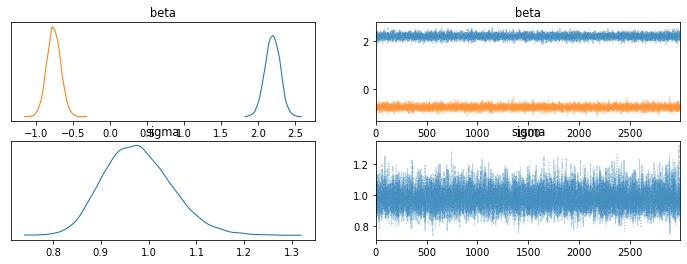

In [97]:
az.plot_trace(result, combined=True);